## Cifar10 VI vs MC Dropout

In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0
!pip install tfp-nightly
#2.0.0-alpha0 geht nur mit nightly

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
print(tf.__version__)
import tensorflow_probability as tfp
print(tfp.__version__)

tfd = tfp.distributions

%matplotlib inline


2.0.0-alpha0
0.7.0-dev20190502


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

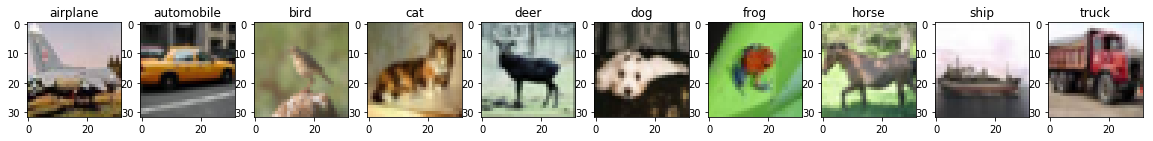

In [4]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
plt.figure(figsize=(20,20))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i])

In [0]:
y_train= tf.keras.utils.to_categorical(y_train)
y_test= tf.keras.utils.to_categorical(y_test)

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=22)


In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(30000, 32, 32, 3)
(30000, 10)
(20000, 32, 32, 3)
(20000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [0]:
## tf norm
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2

## Conv Variational

In [12]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] * 1.0)
model = tf.keras.Sequential()
model.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(32,32,3)))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
#model.add(tf.keras.layers.Dropout((0.3)))
model.add(tfp.layers.DenseFlipout(10, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout_4 (Conv2DFlip (None, 32, 32, 8)         440       
_________________________________________________________________
conv2d_flipout_5 (Conv2DFlip (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_flipout_6 (Conv2DFlip (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_flipout_7 (Conv2DFlip (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

In [13]:
for i in range(0,5):
  print(model.predict(x_train[0:1])[0])
#we get a different pred at every run!

[0.08597066 0.12129564 0.07488927 0.08020346 0.10711797 0.05865708
 0.07352182 0.09558701 0.1843427  0.11841442]
[0.09922963 0.0885286  0.09496179 0.09549691 0.13722275 0.05636286
 0.07411592 0.06103816 0.17801315 0.11503027]
[0.08128313 0.13223706 0.10779952 0.07960341 0.08386265 0.05626567
 0.10880545 0.09309896 0.15254506 0.10449906]
[0.09415207 0.13403381 0.08601449 0.07041932 0.11781755 0.08037166
 0.07746084 0.09211127 0.17585371 0.07176523]
[0.06407557 0.093375   0.1014424  0.10950819 0.10222268 0.05993268
 0.1031999  0.07349346 0.24784036 0.04490975]


In [14]:
history=model.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=100,verbose=1)
# need a lot of epochs
# dropout does not help in terms of train acc and val acc
# longer training would maybe give some improvement

Train on 30000 samples, validate on 20000 samples
Epoch 1/100
30000/30000 [==============================] - 5s 168us/sample - loss: 10.8188 - accuracy: 0.2426 - val_loss: 10.3308 - val_accuracy: 0.3187
Epoch 2/100
30000/30000 [==============================] - 4s 126us/sample - loss: 9.9178 - accuracy: 0.3669 - val_loss: 9.5599 - val_accuracy: 0.4053
Epoch 3/100
30000/30000 [==============================] - 4s 127us/sample - loss: 9.2625 - accuracy: 0.4272 - val_loss: 8.9809 - val_accuracy: 0.4456
Epoch 4/100
30000/30000 [==============================] - 4s 126us/sample - loss: 8.7143 - accuracy: 0.4627 - val_loss: 8.4827 - val_accuracy: 0.4716
Epoch 5/100
30000/30000 [==============================] - 4s 126us/sample - loss: 8.2339 - accuracy: 0.4923 - val_loss: 8.0477 - val_accuracy: 0.4900
Epoch 6/100
30000/30000 [==============================] - 4s 127us/sample - loss: 7.8142 - accuracy: 0.5052 - val_loss: 7.6339 - val_accuracy: 0.5117
Epoch 7/100
30000/30000 [=================

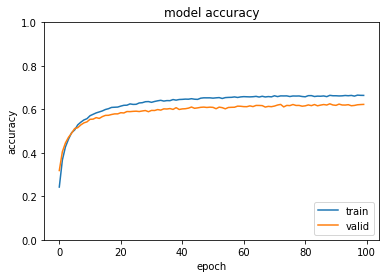

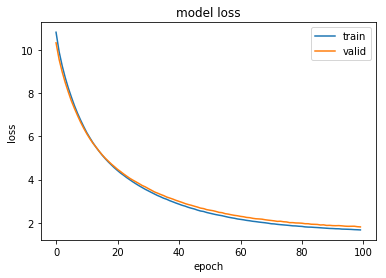

In [15]:

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [0]:
from tqdm import tqdm_notebook as tqdm

In [33]:
# 100 pred and then mean and argmax for the val set
SET=x_val
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(100,1,1,1))
  preds=model.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))

In [57]:
print("val_acc =" ,np.sum(pred.reshape((len(pred)))==np.argmax(y_val,axis=1))/len(SET))
#better acc than it seems when you look at val acc from the fit output (around 62%)

val_acc = 0.6895


In [58]:
# 100 pred and then mean and argmax for the test set
SET=x_test
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(100,1,1,1))
  preds=model.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))

In [64]:
print("test_acc =" ,np.sum(pred.reshape((len(pred)))==np.argmax(y_test,axis=1))/len(SET))

test_acc = 0.6874


## MC Dropout

In [0]:
def MCDropout(rate):
    return tf.keras.layers.Lambda(lambda x: tf.keras.backend.dropout(x, level=rate))

In [69]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model.add(MCDropout((0.3)))
model.add(tf.keras.layers.Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MCDropout((0.3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MCDropout((0.3)))
model.add(tf.keras.layers.Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MCDropout((0.3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(MCDropout((0.3)))
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

W0502 17:44:12.200726 139952810485632 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
lambda (Lambda)              (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
lambda_1 (Lambda)            (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
lambda_2 (Lambda)            (None, 16, 16, 16)       

In [70]:
for i in range(0,5):
  print(model.predict(x_train[0:1])[0])
#we get a different pred at every run!

[0.37098405 0.02084154 0.03485259 0.09651329 0.10803709 0.03514482
 0.04105127 0.04970882 0.17281193 0.07005466]
[0.0550546  0.0256214  0.0655949  0.12054209 0.16685395 0.09692984
 0.09119474 0.1241973  0.09340136 0.16060984]
[0.18068328 0.05704881 0.03294871 0.3198224  0.06523153 0.04062444
 0.02438856 0.08001129 0.08905878 0.11018226]
[0.03922208 0.01408441 0.02496476 0.70870024 0.00799876 0.00379426
 0.02303985 0.05867286 0.03918612 0.08033672]
[0.09735531 0.03422454 0.0222141  0.2137876  0.07129347 0.04672134
 0.04483203 0.26250562 0.12158695 0.08547904]


In [71]:
history=model.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=100,verbose=1)

Train on 30000 samples, validate on 20000 samples
Epoch 1/100
30000/30000 [==============================] - 3s 114us/sample - loss: 1.9958 - accuracy: 0.2688 - val_loss: 1.7515 - val_accuracy: 0.3575
Epoch 2/100
30000/30000 [==============================] - 3s 93us/sample - loss: 1.6374 - accuracy: 0.4010 - val_loss: 1.5569 - val_accuracy: 0.4281
Epoch 3/100
30000/30000 [==============================] - 3s 92us/sample - loss: 1.5035 - accuracy: 0.4521 - val_loss: 1.4641 - val_accuracy: 0.4696
Epoch 4/100
30000/30000 [==============================] - 3s 92us/sample - loss: 1.4112 - accuracy: 0.4887 - val_loss: 1.3926 - val_accuracy: 0.4958
Epoch 5/100
30000/30000 [==============================] - 3s 93us/sample - loss: 1.3597 - accuracy: 0.5088 - val_loss: 1.3561 - val_accuracy: 0.5110
Epoch 6/100
30000/30000 [==============================] - 3s 92us/sample - loss: 1.3219 - accuracy: 0.5218 - val_loss: 1.3305 - val_accuracy: 0.5152
Epoch 7/100
30000/30000 [========================

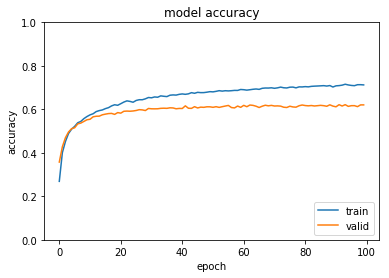

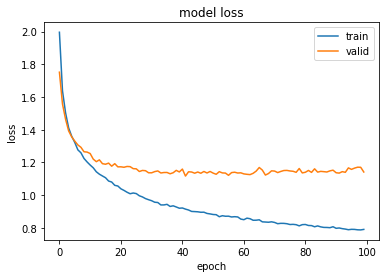

In [72]:

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [73]:
# 100 pred and then mean and argmax for the val set
SET=x_val
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(100,1,1,1))
  preds=model.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))

In [74]:
print("val_acc =" ,np.sum(pred.reshape((len(pred)))==np.argmax(y_val,axis=1))/len(SET))
# Flipout: val_acc = 0.6895

val_acc = 0.70075


In [75]:
# 100 pred and then mean and argmax for the test set
SET=x_test
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(100,1,1,1))
  preds=model.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))

In [76]:
print("test_acc =" ,np.sum(pred.reshape((len(pred)))==np.argmax(y_test,axis=1))/len(SET))
# Flipout: test_acc = 0.6874

test_acc = 0.6972


## Baseline "normal" CNN

In [77]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model.add(tf.keras.layers.Dropout((0.3)))
model.add(tf.keras.layers.Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(tf.keras.layers.Dropout((0.3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(tf.keras.layers.Dropout((0.3)))
model.add(tf.keras.layers.Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(tf.keras.layers.Dropout((0.3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dropout((0.3)))
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 16)        1168      
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 16)       

In [78]:
history=model.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=100,verbose=1)

Train on 30000 samples, validate on 20000 samples
Epoch 1/100
30000/30000 [==============================] - 4s 121us/sample - loss: 1.9593 - accuracy: 0.2888 - val_loss: 1.8683 - val_accuracy: 0.3936
Epoch 2/100
30000/30000 [==============================] - 3s 95us/sample - loss: 1.6711 - accuracy: 0.3933 - val_loss: 1.7075 - val_accuracy: 0.4317
Epoch 3/100
30000/30000 [==============================] - 3s 94us/sample - loss: 1.5402 - accuracy: 0.4408 - val_loss: 1.6458 - val_accuracy: 0.4239
Epoch 4/100
30000/30000 [==============================] - 3s 93us/sample - loss: 1.4642 - accuracy: 0.4714 - val_loss: 1.5626 - val_accuracy: 0.4674
Epoch 5/100
30000/30000 [==============================] - 3s 97us/sample - loss: 1.4109 - accuracy: 0.4903 - val_loss: 1.5157 - val_accuracy: 0.4948
Epoch 6/100
30000/30000 [==============================] - 3s 107us/sample - loss: 1.3645 - accuracy: 0.5061 - val_loss: 1.4424 - val_accuracy: 0.5271
Epoch 7/100
30000/30000 [=======================

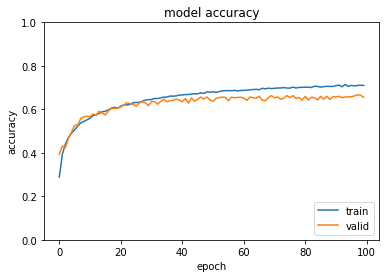

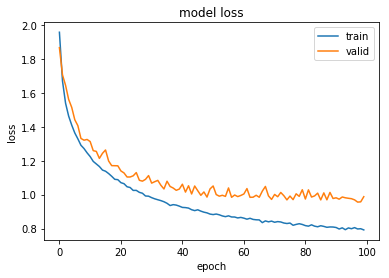

In [79]:

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [85]:
preds=model.predict(x_val)
print("val_acc = ",np.sum(np.argmax(preds,axis=1)==np.argmax(y_val,axis=1))/len(preds))

val_acc =  0.65515


In [87]:
preds=model.predict(x_test)
print("test_acc = ",np.sum(np.argmax(preds,axis=1)==np.argmax(y_test,axis=1))/len(preds))

test_acc =  0.6476


In [88]:
for i in range(0,5):
  print(model.predict(x_train[0:1])[0])
#we get a always tje same pred!

[0.00657312 0.00226444 0.18140481 0.1725519  0.03265724 0.39325875
 0.08825593 0.11313481 0.0011216  0.00877731]
[0.00657312 0.00226444 0.18140481 0.1725519  0.03265724 0.39325875
 0.08825593 0.11313481 0.0011216  0.00877731]
[0.00657312 0.00226444 0.18140481 0.1725519  0.03265724 0.39325875
 0.08825593 0.11313481 0.0011216  0.00877731]
[0.00657312 0.00226444 0.18140481 0.1725519  0.03265724 0.39325875
 0.08825593 0.11313481 0.0011216  0.00877731]
[0.00657312 0.00226444 0.18140481 0.1725519  0.03265724 0.39325875
 0.08825593 0.11313481 0.0011216  0.00877731]


### Results

In [0]:
## Val acc

# Flipout:       val_acc = 0.6895
# MC-Dropout:    val_acc = 0.70075
# Baseline CNN:  val_acc = 0.65515

In [0]:
## Test acc

# Flipout:       test_acc = 0.6874
# MC-Dropout:    test_acc = 0.6972
# Baseline CNN:  test_acc = 0.6476